In [1]:
import random
import time
from copy import deepcopy
import os
import numpy as np
import collections
import matplotlib.pyplot as plt
import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)
import testcopy as test
import torch


Device: cuda
Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])


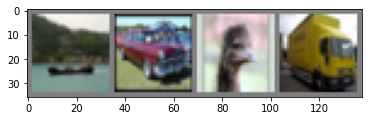

 ship   car  bird truck
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
(50, 4, 32, 30, 30)
(50, 4, 64, 28, 28)
(50, 4, 128, 26, 26)
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
(50, 4, 32, 30, 30)
(50, 4, 64, 28, 28)
(50, 4, 128, 26, 26)


In [2]:
test.run()
random_image_paths = test.create_random_images()
trainloader = test.load_random_images(random_image_paths)
filters = test.get_random_filters()
activations = test.get_activations(trainloader, filters)
for a in activations:
    print(a.shape)

In [3]:
class Model(object):
    def __init__(self):
        self.filters = None
        self.activations = None
        self.fitness = None
#         self.novelty = None

In [4]:
def compute_feature_novelty(activations):
    dist = {0: [], 1: [], 2: []}
    avg_dist = {0: None, 1: None, 2: None}
    for i in range(len(activations)):
        for a in activations[i]:
            for a2 in activations[i]:
                dist[i].append(np.abs(a2 - a))
        avg_dist[i] = np.mean(dist[i])
    return(sum(avg_dist.values()))

In [5]:
def mutate(filters):
    # select a single 3x3 filter in one of the convolutional layers and replace it with a random new filter.
    selected_layer = random.randint(0,len(filters)-1)
    selected_dims = []
    for v in list(filters[selected_layer].shape)[0:2]:
        selected_dims.append(random.randint(0,v-1))
    print('selected_layer', selected_layer, 'selected_dims', selected_dims)
    filters[selected_layer][selected_dims[0]][selected_dims[1]] = torch.tensor(np.random.rand(3,3), device=test.device)
    return filters
   

In [6]:
def evolution(generations, population_size, num_children, tournament_size, num_winners=1, evolution_type="fitness"):
    """Evolutionary Algorithm

    Args:
      generations: the number of generations the algorithm should run for.
      population_size: the number of individuals to keep in the population.
      tournament_size: the number of individuals that should participate in each
          tournament.

    Returns:
      history: a list of `Model` instances, representing all the models computed
          during the evolution experiment.
    """
    population = collections.deque()
    solutions_over_time = []
    fitness_over_time = []

    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.filters = test.get_random_filters()
#         model.filters = mutate(model.filters)
        model.activations = test.get_activations(trainloader, model.filters)
        model.fitness = compute_feature_novelty(model.activations)
        population.append(model)
        
    # Carry out evolution in cycles. Each cycle produces a model and removes
    # another.
    for i in range(generations):
#     while len(history) < generations:
        
        parents = []  
        while len(parents) < num_children and evolution_type != "random":
        # Sample randomly chosen models from the current population.
            tournament = []
            while len(tournament) < tournament_size:
            # Inefficient, but written this way for clarity. In the case of neural
            # nets, the efficiency of this line is irrelevant because training neural
            # nets is the rate-determining step.
                candidate = random.choice(list(population))
                tournament.append(candidate)

            # The parent is the best model in the sample.
            parents.extend(sorted(tournament, key=lambda i: i.fitness, reverse=True)[:num_winners])
        

        # Create the child model and store it.
        for parent in parents:
            child = Model()
            child.filters = mutate(parent.filters)
            child.activations = test.get_activations(trainloader, child.filters)
            child.fitness = compute_feature_novelty(child.activations)
            population.append(child)
            
        if evolution_type == 'fitness':
            population = sorted(population, key=lambda i: i.fitness, reverse=True)[:population_size]
        
        if evolution_type == 'random':
            population = [sorted(population, key=lambda i: i.fitness, reverse=True)[0]]
            while len(population) < population_size:
                model = Model()
                model.filters = test.get_random_filters()
                model.activations = test.get_activations(trainloader, model.filters)
                model.fitness = compute_feature_novelty(model.activations)
                population.append(model)
        
        fitness_over_time.append(1+(sorted(population, key=lambda i: i.fitness, reverse=True)[0].fitness))
        solutions_over_time.append((sorted(population, key=lambda i: i.fitness, reverse=True)[0].filters))
        
    return solutions_over_time, np.array(fitness_over_time)

In [7]:
num_runs = 20
run_id = 0
n_iters = 100
output_path = './'
pop_size = 50
tournament_size = 10
num_children = 50
num_winners = 5

fitness_results = {}
solution_results = {}

In [ ]:
for run_name in ['fitness', 'random']:
    fitness_results[run_name] = np.zeros((num_runs, n_iters))
    solution_results[run_name] = np.array([[Model() for i in range(n_iters)]for j in range(num_runs)], dtype=object)
    new_output_path = os.path.join(output_path, run_name + "evolution")
    os.makedirs(os.path.join(new_output_path), exist_ok=True)
    for run_num in range(num_runs):
        start_time = time.time()
        solution_over_time, fitness_over_time = evolution(generations=n_iters, population_size=pop_size, num_children=num_children, tournament_size=tournament_size, num_winners=num_winners, evolution_type=run_name)
        fitness_results[run_name][run_num] = fitness_over_time
        solution_results[run_name][run_num] = solution_over_time
        res = [solution_results, fitness_results]
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])
    

torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([32, 3, 3, 3])
to

selected_layer 2 selected_dims [49, 3]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [15, 28]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [125, 61]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [47, 53]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [17, 28]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [14, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [20, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [77, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [96

selected_layer 0 selected_dims [14, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [11, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [120, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [37, 3]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [63, 57]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [6, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [15, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 1]

selected_layer 2 selected_dims [35, 45]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [27, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [39, 12]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [42, 19]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [45, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [109, 55]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [13, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0,

selected_layer 2 selected_dims [86, 45]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [49, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [3, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [104, 49]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [24, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [27, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [61, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [7, 0]

selected_layer 2 selected_dims [59, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [15, 62]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [109, 40]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [48, 27]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [98, 41]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [61, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [21,

selected_layer 1 selected_dims [56, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [44, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [127, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [51, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [10, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [38, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [91, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [34, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [4,

selected_layer 1 selected_dims [49, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [56, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [21, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [7, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [11, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [26, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [55, 41]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [50,

selected_layer 1 selected_dims [14, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [29, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [3, 13]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [14, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [113, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [121, 57]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [35, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [14, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [11

selected_layer 2 selected_dims [73, 41]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [42, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [94, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [18, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [51, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [54, 24]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [4, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62,

selected_layer 1 selected_dims [51, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [20, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [18, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [10, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [30, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [68, 55]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [26, 7]

selected_layer 2 selected_dims [105, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [19, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [45, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [26, 38]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [70, 24]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [2, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [15, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [27, 48]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [7, 

selected_layer 0 selected_dims [8, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [122, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [60, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [69, 62]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [18, 56]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [21, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 1]

selected_layer 1 selected_dims [24, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [22, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [17, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [15, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [42, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [32, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 0]
t

selected_layer 0 selected_dims [7, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [62, 32]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [29, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [123, 37]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [54, 24]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [39, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [19, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [34, 

selected_layer 2 selected_dims [14, 55]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [17, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [70, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [48, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [34, 10]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [125, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [59, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [59

selected_layer 1 selected_dims [42, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [21, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [9, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [85, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [85, 60]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [15, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [17, 31]

selected_layer 1 selected_dims [4, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [12, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [10, 3]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [28, 13]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [6, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [79, 44]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [67, 23

selected_layer 1 selected_dims [52, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [59, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [12, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [57, 19]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [63, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [26, 7]


selected_layer 1 selected_dims [7, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [115, 32]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [12, 24]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [36, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [59, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [18, 0]


selected_layer 2 selected_dims [52, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [53, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [54, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [21, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [19, 35]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [51, 12

selected_layer 2 selected_dims [61, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [43, 52]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [26, 33]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [20, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [23, 19]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [19, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [14, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [118

selected_layer 2 selected_dims [28, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [4, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [7, 3]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [41, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [7, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [64, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [50, 0]
to

selected_layer 2 selected_dims [5, 62]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [37, 12]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [8, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [12, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [6, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [70, 55]
t

selected_layer 1 selected_dims [23, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [27, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [20, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [46, 33]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [9, 33]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [25, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 0]
t

selected_layer 1 selected_dims [16, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [61, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [37, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [85, 39]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [117, 48]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [103, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [61, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [9

selected_layer 0 selected_dims [20, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [3, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [69, 49]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [22, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [22, 0]
to

selected_layer 2 selected_dims [5, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [103, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [45, 42]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [58, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [70, 44]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [33, 59]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [17, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46,

selected_layer 2 selected_dims [68, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [27, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [17, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [11, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [29, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [5, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [25, 2]
t

selected_layer 1 selected_dims [59, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [25, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [104, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [20, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [8, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [28, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [65, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [56, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [127

selected_layer 2 selected_dims [34, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [5, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [58, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [17, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [27, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [16, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [67, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 2]
tor

selected_layer 0 selected_dims [28, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [41, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [25, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [118, 40]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [62, 40]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [85, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [18, 24]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [11

selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [31, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [92, 35]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [29, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [64, 51]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [7, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [45, 45]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [56, 18]


selected_layer 1 selected_dims [48, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [76, 62]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [11, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [63, 10]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [18, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [117, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [33, 

selected_layer 1 selected_dims [50, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [10, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [8, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [16, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [49, 33]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [26, 3]
to

selected_layer 0 selected_dims [20, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [79, 60]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [12, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [26, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [93, 27]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]


selected_layer 1 selected_dims [37, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [79, 40]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [101, 53]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [61, 12]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [61, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [38, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 25]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [

selected_layer 1 selected_dims [17, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [48, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [45, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [21, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [42, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [16, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [31, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 0]
t

selected_layer 0 selected_dims [19, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [46, 61]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [58, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [6, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [90, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [38, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [90, 59]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [4, 56]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [6, 30

selected_layer 1 selected_dims [0, 12]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [104, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [90, 42]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [53, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [49, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [16, 28]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [121, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [19, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [5

selected_layer 1 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [93, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [60, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [23, 41]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [68, 32]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [119, 40]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [30, 

selected_layer 1 selected_dims [29, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [58, 13]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [25, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [22, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [37, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [55, 22

selected_layer 0 selected_dims [0, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [5, 15]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [38, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46, 16]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [16, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [31, 43]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [95, 56]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [41, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [24, 

selected_layer 0 selected_dims [13, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [27, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [26, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [30, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [83, 30]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [71, 54]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [39, 7]


selected_layer 1 selected_dims [31, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [11, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [41, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [11, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [82, 49]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [16, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [62, 7]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [57, 1

selected_layer 2 selected_dims [42, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [48, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [49, 39]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [4, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [12, 58]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [91, 63]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [16, 

selected_layer 1 selected_dims [2, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [14, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [99, 13]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [3, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [5, 5]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [22, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [78, 3]
t

selected_layer 0 selected_dims [5, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [30, 3]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [0, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [34, 43]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [2, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [56, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [127, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 1]

selected_layer 1 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [69, 26]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [38, 33]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [58, 20]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [51, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [46, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [104, 63]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [24, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [22,

selected_layer 0 selected_dims [4, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [99, 36]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [29, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [125, 17]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [9, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [15, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [39, 6]
to

selected_layer 2 selected_dims [68, 18]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [13, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [70, 27]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [15, 21]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [72, 49]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [84, 42]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [92, 45]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [12,

selected_layer 2 selected_dims [117, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [99, 61]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [98, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [32, 34]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [12, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [56, 23]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [29, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [7, 

selected_layer 0 selected_dims [14, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [23, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [22, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [15, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [93, 51]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [4, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [126, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 0]
t

selected_layer 1 selected_dims [62, 28]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [36, 11]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [14, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [39, 31]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [3, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [15, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [6, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [42, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [21, 2]


selected_layer 1 selected_dims [32, 19]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [57, 32]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [30, 46]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [43, 4]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [19, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 19]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [1, 49]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [16, 29]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [1, 

selected_layer 2 selected_dims [48, 38]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [23, 27]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [5, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [56, 62]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [14, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [107, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [29, 22]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [39, 45]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [42

selected_layer 2 selected_dims [89, 6]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [0, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [50, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [6, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [113, 32]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [62, 8]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 2 selected_dims [92, 38]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [18, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [8, 2]
t

selected_layer 1 selected_dims [16, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [30, 0]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [11, 1]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [11, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [32, 9]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [7, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 0 selected_dims [28, 2]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [6, 14]
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
selected_layer 1 selected_dims [4, 1]
to